**Problem Statement**

You work at a company, XYZ, that builds the best chatbots.
A typical client for XYZ has a website and wants to add a virtual
assistant that can help me find answers to my questions.
A client has heard about the success of XYZ. So, that client decided
to get help from XYZ. The client will give XYZ a URL, and XYZ will
build that virtual assistant (or chatbot) that answers questions only
from the content on the website.

**Solution Architecture**


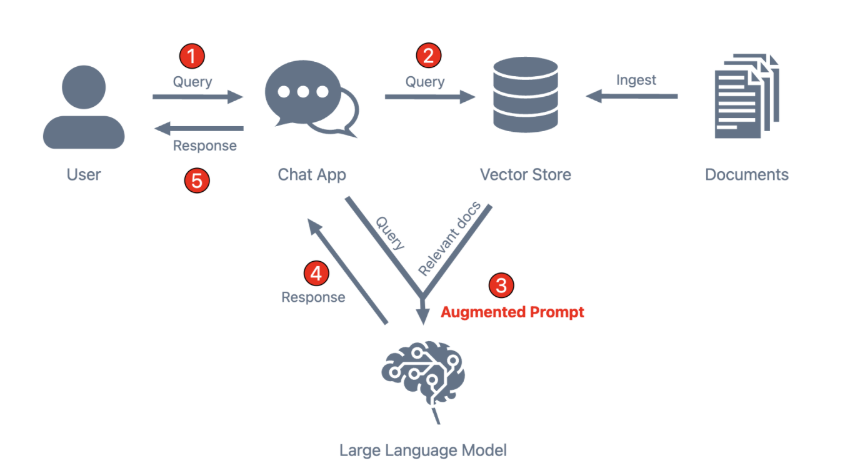

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma bs4
%pip install -qU langchain-openai

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [ ]:
from langchain_openai import ChatOpenAI
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [ ]:
# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [ ]:
# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
print("Response is\n------")
print(response["answer"])

Response is
------
Task decomposition is a technique used to break down complex tasks into smaller and simpler steps. It allows agents to manage and tackle intricate tasks more effectively by dividing them into manageable components. Different methods, such as Chain of Thought and Tree of Thoughts, help in decomposing tasks and guiding the agent's decision-making process.


# Adding History

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are common ways of doing it?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Common ways of task decomposition include using techniques like Chain of Thought (CoT) or Tree of Thoughts to guide the model in breaking down complex tasks into smaller steps. Additionally, task decomposition can be achieved through simple prompting with language models, task-specific instructions tailored to the nature of the task, or with human inputs to provide guidance on breaking down the task effectively.
